In [100]:
# Regular Imports
import os
from os import listdir
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pydicom
import re
import seaborn as sns
import os
import numpy as np
import pandas as pd
import pydicom
import re
import seaborn as sns
import warnings
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn import ensemble
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from plotly.offline import init_notebook_mode
import scipy.ndimage
from skimage.morphology import disk, closing
from tqdm import tqdm
from PIL import Image
from os import listdir

# Segmentation
from skimage import morphology
from skimage import measure
from sklearn.cluster import KMeans
from plotly.offline import init_notebook_mode
init_notebook_mode(connected=True)

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline
IMAGE_PATH = "../input/osic-pulmonary-fibrosis-progression/"

  Cloning https://github.com/JoHof/lungmask to /tmp/pip-req-build-fsnv3l8w
  Running command git clone -q https://github.com/JoHof/lungmask /tmp/pip-req-build-fsnv3l8w
  Created wheel for lungmask: filename=lungmask-0.2.8-py3-none-any.whl size=25333 sha256=a7f780b5d5b98882cc57ca6118e97f1658562a9991b07004aa78e133833f724b
  Stored in directory: /tmp/pip-ephem-wheel-cache-s3___cc3/wheels/52/15/e5/5091d6960bade2f75f0d518b4d8234b5d4978eb9ce045300d1
Successfully built lungmask
spacing (0.693359375, 0.693359375, 1.000000003460208)
Pixel volume: 0.480747224563876
Image size: 512 512 290
INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!
all lung pixels 7515858
lung volume cm3: 3613.227873716204

INFO:root:No GPU support available, will use CPU. Note, that this is significantly slower!
all lung pixels 7364474
lung volume cm3: 3540.450435872826


100%|██████████| 8/8 [00:00<00:00, 51.63it/s]
Downloading: "https://github.com/JoHof/lungmask/releases/download/v0.0/unet_ltrclobes-3a07043d.pth" to /home/andreas/.cache/torch/hub/checkpoints/unet_ltrclobes-3a07043d.pth
100%|██████████| 157/157 [00:02<00:00, 61.63it/s]


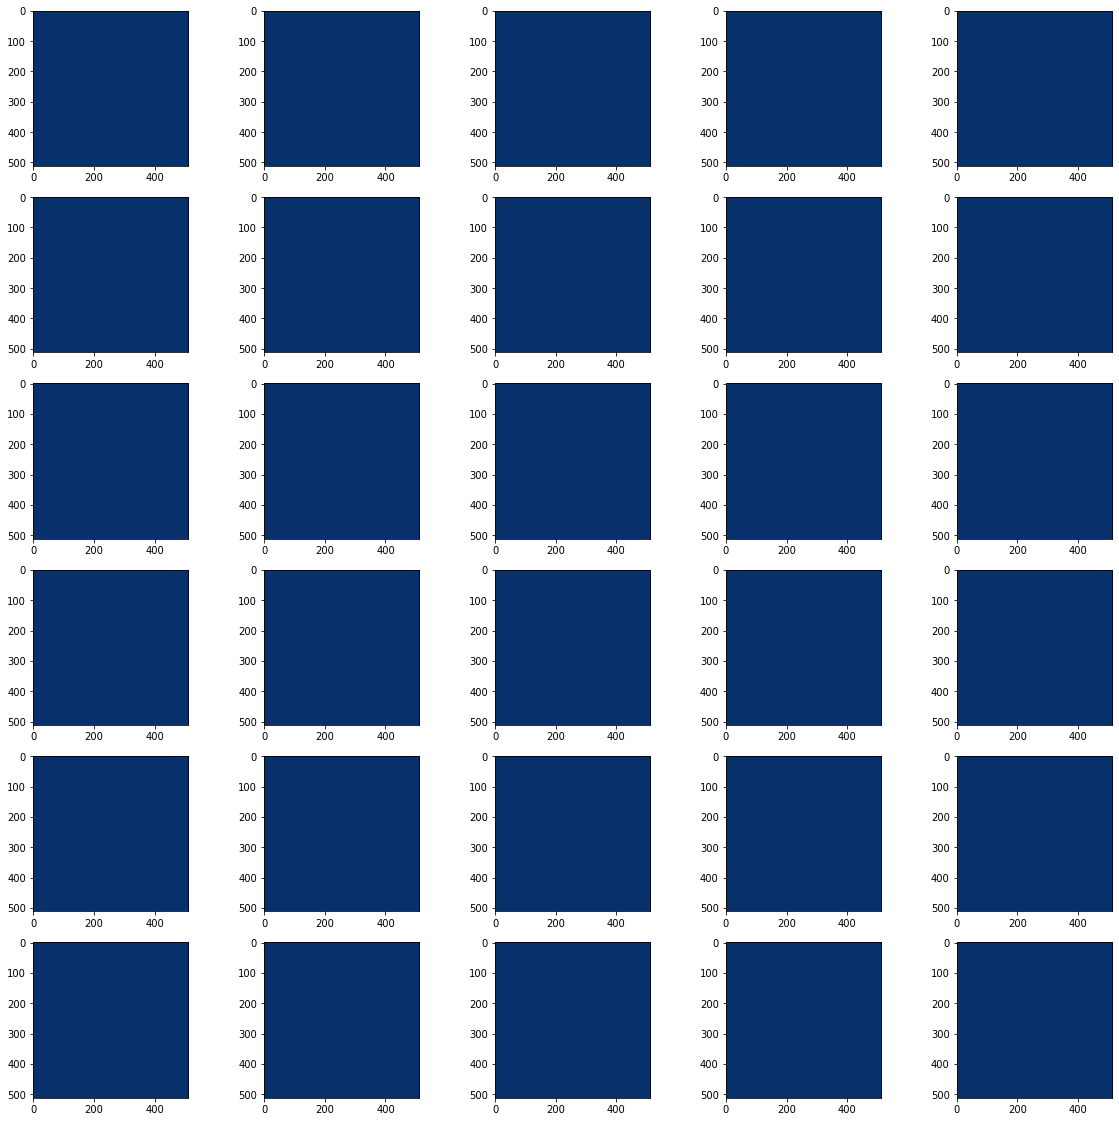

In [108]:
def load_scans(dcm_path):
    try:
        # in this competition we have missing values in ImagePosition, this is why we are sorting by filename number
        files = listdir(dcm_path)
        file_nums = [np.int(file.split(".")[0]) for file in files]
        sorted_file_nums = np.sort(file_nums)[::-1]
        slice_factor = 1
        if 100 <= len(sorted_file_nums) < 300:
            slice_factor = 2
        if 300 <= len(sorted_file_nums):
            slice_factor = 4
        sorted_file_nums = sorted_file_nums[0:len(sorted_file_nums):slice_factor]
        slices = [pydicom.dcmread(dcm_path + "/" + str(file_num) + ".dcm" ) for file_num in sorted_file_nums]
        return slices, slice_factor
    except:
        print('Could not load scans')

def transform_to_hu(slices):
    try:
        images = np.stack([file.pixel_array for file in slices])
        images = images.astype(np.int16)

        # convert ouside pixel-values to air:
        # I'm using <= -1000 to be sure that other defaults are captured as well
        images[images <= -1000] = 0

        # convert to HU
        for n in range(len(slices)):

            intercept = slices[n].RescaleIntercept
            slope = slices[n].RescaleSlope

            if slope != 1:
                images[n] = slope * images[n].astype(np.float64)
                images[n] = images[n].astype(np.int16)

            images[n] += np.int16(intercept)

        return np.array(images, dtype=np.int16)
    except:
        print('error in converting to HU')

def segment_lung_mask(images_array):
    try:
        segmented_array = np.zeros(images_array.shape)
        width = segmented_array.shape[1]
        height = segmented_array.shape[2]
        masks_array = np.zeros(images_array.shape)
        images_to_be_removed = []

        for n in range(images_array.shape[0]):
            binary_image = np.array(images_array[n] > -320, dtype=np.int8)+1
            labels = measure.label(binary_image)

            background_labels_up = np.unique(labels[0,:])
            background_labels_down = np.unique(labels[-1,:])
            background_labels_left = np.unique(labels[:,0])
            background_labels_right = np.unique(labels[:,-1])
            background_labels = np.concatenate((background_labels_up, background_labels_down, background_labels_left, background_labels_right))
            background_mask = np.isin(labels, background_labels)

            # background_label_1 = labels[0,0]
            # background_label_2 = labels[0,-1]
            # background_label_3 = labels[-1,0]
            # background_label_4 = labels[-1,-1]
            # background_label_5 = labels[0,int(np.ceil(width/2))]
            # background_label_6 = labels[int(np.ceil(height/2)),-1]
            # background_label_7 = labels[-1,int(np.ceil(width/2))]
            # background_label_8 = labels[int(np.ceil(height/2)),-1]


            #Fill the air around the person
            binary_image[background_mask == True] = 2
            # binary_image[background_label_1 == labels] = 2
            # binary_image[background_label_2 == labels] = 2
            # binary_image[background_label_3 == labels] = 2
            # binary_image[background_label_4 == labels] = 2
            # binary_image[background_label_5 == labels] = 2
            # binary_image[background_label_6 == labels] = 2
            # binary_image[background_label_7 == labels] = 2
            # binary_image[background_label_8 == labels] = 2

            binary_image -= 1 #Make the image actual binary
            binary_image = 1-binary_image # Invert it, lungs are now 1

            binary_image = morphology.erosion(binary_image,np.ones([3,3]))
            binary_image = morphology.dilation(binary_image,np.ones([18,18]))
            binary_image = morphology.erosion(binary_image,disk(8))

            if np.mean(binary_image > 0) > 0.02:
                masks_array[n] = binary_image.copy()
                segmented_array[n] = masks_array[n] * images_array[n]
            else:
                images_to_be_removed.append(n)

        segmented_array = np.delete(segmented_array, images_to_be_removed, axis=0)
        print('Original shape: ', images_array.shape, 'Cleaned shape: ', segmented_array.shape)
        return segmented_array, masks_array

    except:
        print('segment lung mask error')

def create_scan_properties_df(df_raw, n):
    try:
        if n is None:
            n = df_raw.Patient.unique().shape[0]

        pixelspacing_r = []
        pixelspacing_c = []
        slice_thicknesses = []
        patient_id = []
        patient_pth = []
        row_values = []
        column_values = []
        window_widths = []
        window_levels = []

        patients = df_raw.Patient.unique()[0:n]

        for patient in patients:
            patient_id.append(patient)
            path = df_raw[df_raw.Patient == patient].dcm_path.values[0]

            example_dcm = listdir(path)[0]
            patient_pth.append(path)
            dataset = pydicom.dcmread(path + "/" + example_dcm)

            window_widths.append(get_window_value(dataset.WindowWidth))
            window_levels.append(get_window_value(dataset.WindowCenter))

            spacing = dataset.PixelSpacing
            slice_thicknesses.append(dataset.SliceThickness)

            row_values.append(dataset.Rows)
            column_values.append(dataset.Columns)
            pixelspacing_r.append(spacing[0])
            pixelspacing_c.append(spacing[1])

        scan_properties = pd.DataFrame(data=patient_id, columns=["patient"])
        scan_properties.loc[:, "rows"] = row_values
        scan_properties.loc[:, "columns"] = column_values
        scan_properties.loc[:, "area"] = scan_properties["rows"] * scan_properties["columns"]
        scan_properties.loc[:, "pixelspacing_r"] = pixelspacing_r
        scan_properties.loc[:, "pixelspacing_c"] = pixelspacing_c
        scan_properties.loc[:, "pixelspacing_area"] = scan_properties.pixelspacing_r * scan_properties.pixelspacing_c
        scan_properties.loc[:, "slice_thickness"] = slice_thicknesses
        scan_properties.loc[:, "patient_pth"] = patient_pth
        scan_properties.loc[:, "window_width"] = window_widths
        scan_properties.loc[:, "window_level"] = window_levels

        scan_properties["r_distance"] = scan_properties.pixelspacing_r * scan_properties.rows
        scan_properties["c_distance"] = scan_properties.pixelspacing_c * scan_properties["columns"]
        scan_properties["area_cm2"] = 0.1* scan_properties["r_distance"] * 0.1*scan_properties["c_distance"]
        scan_properties["slice_volume_cm3"] = 0.1*scan_properties.slice_thickness * scan_properties.area_cm2

        scan_properties["lung_pixels_and_slices"] = scan_properties.apply(lambda x: get_lung_pixels_and_slices(x.patient_pth), axis=1)
        return scan_properties
    except:
        print('Could not create scan properties')


def get_window_value(feature):
    try:
        if type(feature) == pydicom.multival.MultiValue:
            return np.int(feature[0])
        else:
            return np.int(feature)
    except:
        print('Could not get window value')


def get_lung_pixels_and_slices(patient_path):
    try:
        slices, slice_factor = load_scans(patient_path)
        hu_scans = transform_to_hu(slices)
        segmented_array, masks_array = segment_lung_mask(hu_scans)

        return np.count_nonzero(segmented_array), segmented_array.shape[0]
    except:
        print('error for patient', patient_path)


In [ ]:
!pip install git+https://github.com/JoHof/lungmask
from lungmask import mask
import SimpleITK as sitk

patient = 'ID00423637202312137826377'
reader = sitk.ImageSeriesReader()
dicom_names = reader.GetGDCMSeriesFileNames('../input/osic-pulmonary-fibrosis-progression/train/' + patient)
reader.SetFileNames(dicom_names)
image = reader.Execute()
size = image.GetSize()
print('spacing', image.GetSpacing())
length, width, height = image.GetSpacing()
pixel_volume = length * width * height
print('Pixel volume:', pixel_volume)
print("Image size:", size[0], size[1], size[2])

segmentation = mask.apply(image)
lung_pixels = np.count_nonzero(segmentation)
print('all lung pixels', lung_pixels)
print('lung volume cm3:', pixel_volume * lung_pixels / 1000)

model = mask.get_model('unet','LTRCLobes')
segmentation2 = mask.apply(image, model)
lung_pixels2 = np.count_nonzero(segmentation2)
print('all lung pixels', lung_pixels2)
print('lung volume cm3:', pixel_volume * lung_pixels2 / 1000)

fig, ax = plt.subplots(6, 5, figsize=(20,20))
for n in range(6):
    for m in range(5):
        # ax[n,m].imshow(set_manual_window(segmented_lungs[(n+1)*5+m], 40, 10), cmap="Blues_r")
        # ax[n,m].imshow(set_manual_window(segmented_lungs[(n+1)*5+m], -700, 255), cmap="Blues_r")
        ax[n,m].imshow(segmentation[(n+1)*5+m], cmap="Blues_r")

In [ ]:
scan_properties_df = create_scan_properties_df(df_train, 1)
scan_properties_df.to_pickle(PICKLE_OUTPUT_DIR + "/scan_properties_df.pkl", protocol=2)
scan_properties_df.head()